In [19]:
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
    print('Colab detected: Drive mounted.')
else:
    print('Running locally: skipping Google Drive mount.')

Running locally: skipping Google Drive mount.


# Trading Behavior vs Market Sentiment Analysis
# Analyzing the relationship between Hyperliquid trader behavior and Bitcoin Fear & Greed Index


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import warnings
import os
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Ensure outputs directory exists for saving figures
outputs_dir = Path('outputs')
outputs_dir.mkdir(exist_ok=True)

def savefig_current(name: str):
    """Save current matplotlib figure to outputs directory."""
    plt.savefig(outputs_dir / name, dpi=200, bbox_inches='tight')

In [21]:
import importlib.util
import os

if 'IN_COLAB' not in globals():
    IN_COLAB = importlib.util.find_spec('google.colab') is not None

if IN_COLAB:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive', force_remount=False)
    os.chdir('/content/drive/MyDrive/ds_Nikita_Patra')
    print('Drive mounted and Directory set!')
else:
    print('Local run: using current working directory.')

Local run: using current working directory.


In [22]:
# Load the Fear & Greed Index dataset
fg_df = pd.read_csv('csv_files/fear_greed_index.csv')
fg_df['date'] = pd.to_datetime(fg_df['date'])

# Load the Historical Trading Data
trades_df = pd.read_csv('csv_files/historical_data.csv')

print("Fear & Greed Index Dataset:")
print(f"Shape: {fg_df.shape}")
print(f"Date Range: {fg_df['date'].min()} to {fg_df['date'].max()}")
print(f"\nSample data:")
print(fg_df.head())

print("\n" + "="*80 + "\n")

print("Historical Trading Data:")
print(f"Shape: {trades_df.shape}")
print(f"\nSample data:")
print(trades_df.head())

Fear & Greed Index Dataset:
Shape: (2644, 4)
Date Range: 2018-02-01 00:00:00 to 2025-05-02 00:00:00

Sample data:
    timestamp  value classification       date
0  1517463000     30           Fear 2018-02-01
1  1517549400     15   Extreme Fear 2018-02-02
2  1517635800     40           Fear 2018-02-03
3  1517722200     24   Extreme Fear 2018-02-04
4  1517808600     11   Extreme Fear 2018-02-05


Historical Trading Data:
Shape: (211224, 16)

Sample data:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02

In [23]:
# Data Cleaning and Preprocessing
# Convert timestamp to datetime
trades_df['Timestamp IST'] = pd.to_datetime(trades_df['Timestamp IST'], format='%d-%m-%Y %H:%M')
trades_df['date'] = trades_df['Timestamp IST'].dt.date
trades_df['date'] = pd.to_datetime(trades_df['date'])

# Check data types and missing values
print("Trading Data Info:")
print(trades_df.info())
print(f"\nMissing values:\n{trades_df.isnull().sum()}")

print("\n" + "="*80 + "\n")

print("Fear & Greed Index Info:")
print(fg_df.info())
print(f"\nMissing values:\n{fg_df.isnull().sum()}")

Trading Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Account           211224 non-null  object        
 1   Coin              211224 non-null  object        
 2   Execution Price   211224 non-null  float64       
 3   Size Tokens       211224 non-null  float64       
 4   Size USD          211224 non-null  float64       
 5   Side              211224 non-null  object        
 6   Timestamp IST     211224 non-null  datetime64[ns]
 7   Start Position    211224 non-null  float64       
 8   Direction         211224 non-null  object        
 9   Closed PnL        211224 non-null  float64       
 10  Transaction Hash  211224 non-null  object        
 11  Order ID          211224 non-null  int64         
 12  Crossed           211224 non-null  bool          
 13  Fee               211224 non-null  float

## 2. Exploratory Data Analysis

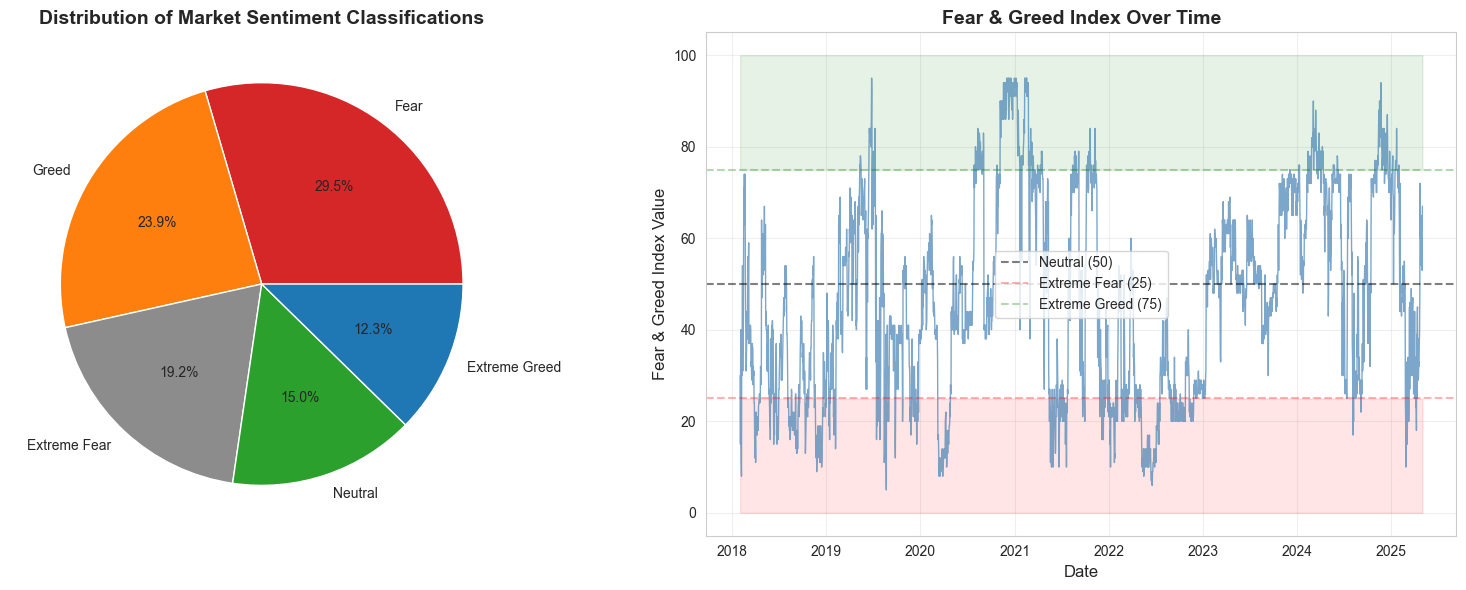


Sentiment Statistics:
                count       mean       std   min   25%   50%    75%   max
classification                                                           
Extreme Fear    508.0  18.273622  4.699441   5.0  14.0  20.0  22.00  24.0
Extreme Greed   326.0  82.116564  6.532657  75.0  76.0  80.0  87.75  95.0
Fear            781.0  34.184379  6.092182  25.0  28.0  34.0  40.00  44.0
Greed           633.0  65.846761  6.246282  55.0  61.0  66.0  72.00  74.0
Neutral         396.0  49.964646  2.645993  45.0  48.0  50.0  52.00  54.0


In [24]:
# Explore Fear & Greed Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution of sentiment classifications
sentiment_counts = fg_df['classification'].value_counts()
axes[0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
            colors=['#d62728', '#ff7f0e', '#8c8c8c', '#2ca02c', '#1f77b4'])
axes[0].set_title('Distribution of Market Sentiment Classifications', fontsize=14, fontweight='bold')

# Fear & Greed Index over time
axes[1].plot(fg_df['date'], fg_df['value'], linewidth=1, color='steelblue', alpha=0.7)
axes[1].axhline(y=50, color='black', linestyle='--', alpha=0.5, label='Neutral (50)')
axes[1].axhline(y=25, color='red', linestyle='--', alpha=0.3, label='Extreme Fear (25)')
axes[1].axhline(y=75, color='green', linestyle='--', alpha=0.3, label='Extreme Greed (75)')
axes[1].fill_between(fg_df['date'], 0, 25, color='red', alpha=0.1)
axes[1].fill_between(fg_df['date'], 75, 100, color='green', alpha=0.1)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Fear & Greed Index Value', fontsize=12)
axes[1].set_title('Fear & Greed Index Over Time', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
savefig_current('fear_greed_overview.png')
plt.show()

print(f"\nSentiment Statistics:")
print(fg_df.groupby('classification')['value'].describe())

Trading Data Summary:
Total number of trades: 211,224
Number of unique traders: 32
Number of unique coins/symbols: 246
Date Range: 2023-05-01 00:00:00 to 2025-05-01 00:00:00


Trade Direction Distribution:
Side
SELL    108528
BUY     102696
Name: count, dtype: int64

Percentage:
Side
SELL    51.380525
BUY     48.619475
Name: proportion, dtype: float64


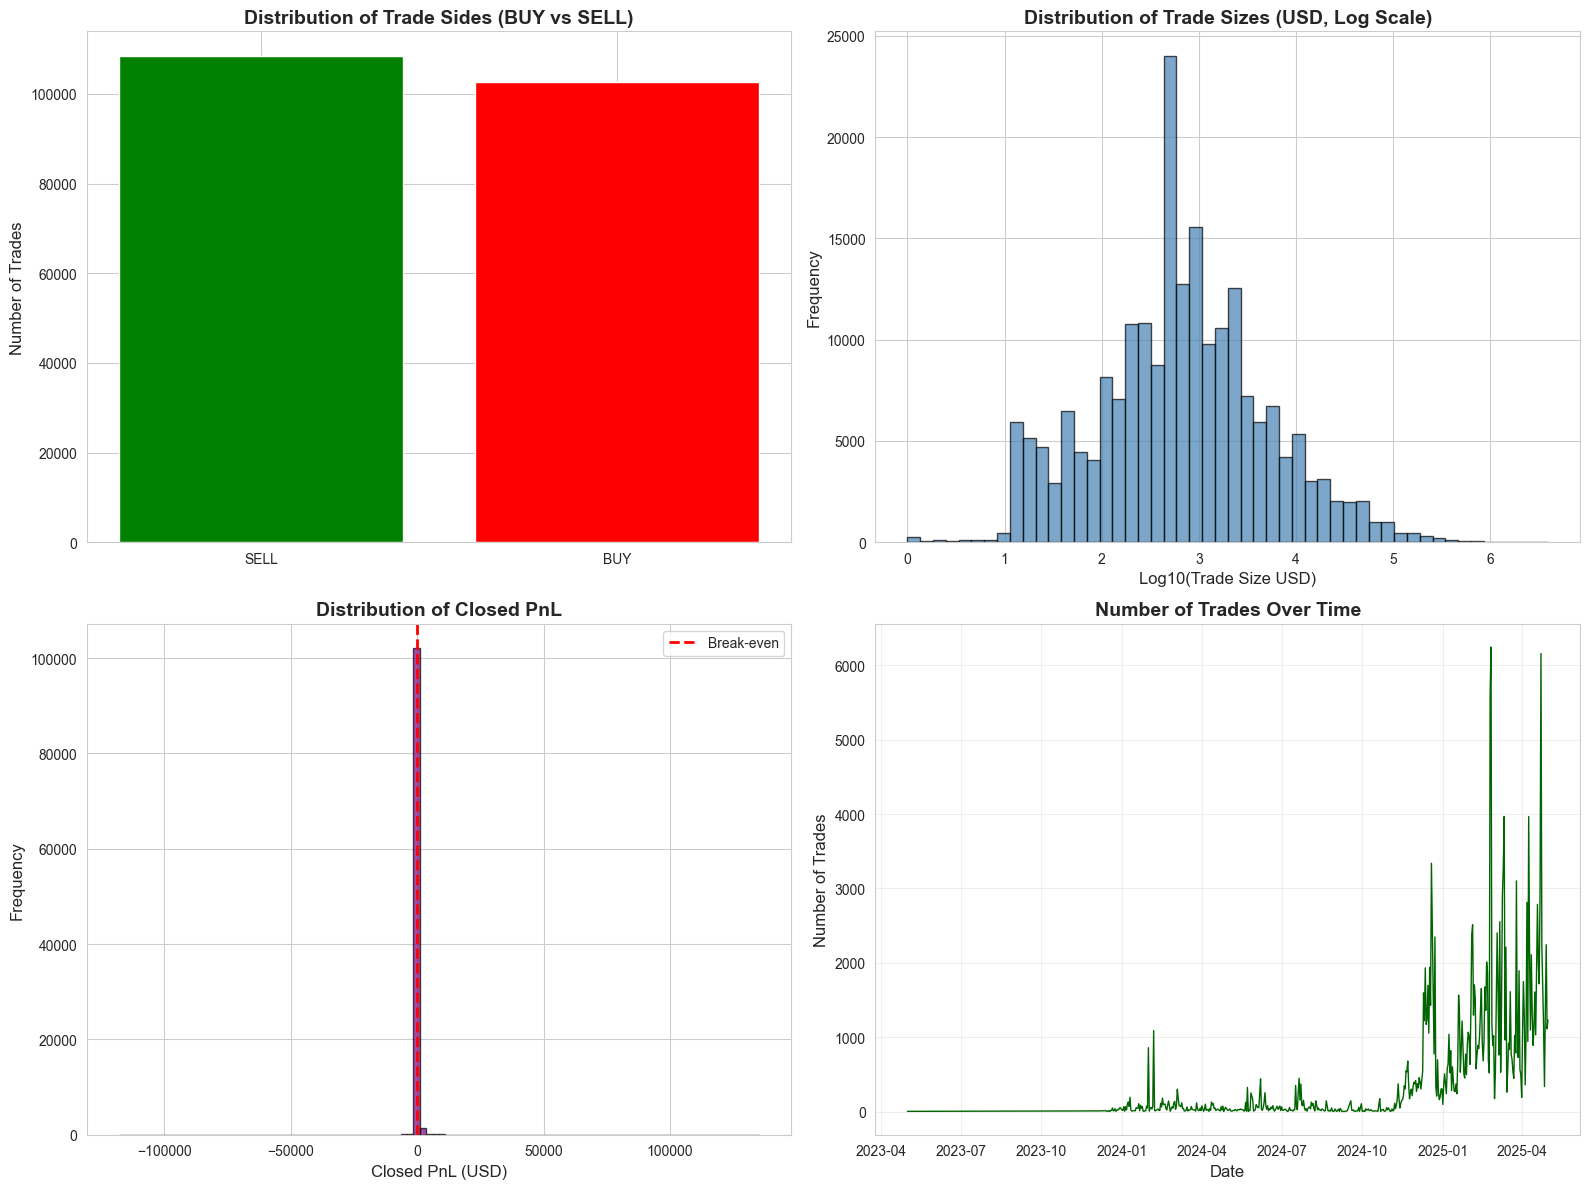

In [25]:
# Explore Trading Data
print("Trading Data Summary:")
print(f"Total number of trades: {len(trades_df):,}")
print(f"Number of unique traders: {trades_df['Account'].nunique()}")
print(f"Number of unique coins/symbols: {trades_df['Coin'].nunique()}")
print(f"Date Range: {trades_df['date'].min()} to {trades_df['date'].max()}")

print("\n" + "="*80 + "\n")

# Trade direction distribution
print("Trade Direction Distribution:")
print(trades_df['Side'].value_counts())
print(f"\nPercentage:\n{trades_df['Side'].value_counts(normalize=True) * 100}")

# Visualize trade characteristics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Trade side distribution
side_counts = trades_df['Side'].value_counts()
axes[0, 0].bar(side_counts.index, side_counts.values, color=['green', 'red'])
axes[0, 0].set_title('Distribution of Trade Sides (BUY vs SELL)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Number of Trades', fontsize=12)

# Trade size distribution (log scale)
axes[0, 1].hist(np.log10(trades_df['Size USD'] + 1), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Trade Sizes (USD, Log Scale)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Log10(Trade Size USD)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)

# PnL distribution (only for closed positions)
closed_trades = trades_df[trades_df['Closed PnL'] != 0]
axes[1, 0].hist(closed_trades['Closed PnL'], bins=100, color='purple', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Break-even')
axes[1, 0].set_title('Distribution of Closed PnL', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Closed PnL (USD)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].legend()

# Trades over time
daily_trades = trades_df.groupby('date').size()
axes[1, 1].plot(daily_trades.index, daily_trades.values, color='darkgreen', linewidth=1)
axes[1, 1].set_title('Number of Trades Over Time', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Date', fontsize=12)
axes[1, 1].set_ylabel('Number of Trades', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
savefig_current('trading_summary.png')
plt.show()

## 3. Merging Datasets - Trading Behavior with Market Sentiment

In [26]:
# Merge trading data with sentiment data
merged_df = trades_df.merge(fg_df[['date', 'value', 'classification']], on='date', how='inner')

print(f"Merged dataset shape: {merged_df.shape}")
print(f"Date range after merge: {merged_df['date'].min()} to {merged_df['date'].max()}")
print(f"\nNumber of trades by sentiment:")
print(merged_df['classification'].value_counts())
print(f"\nSample merged data:")
print(merged_df[['Account', 'Coin', 'Side', 'Size USD', 'Closed PnL', 'date', 'value', 'classification']].head(10))

Merged dataset shape: (211218, 19)
Date range after merge: 2023-05-01 00:00:00 to 2025-05-01 00:00:00

Number of trades by sentiment:
classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64

Sample merged data:
                                      Account  Coin Side  Size USD  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107  BUY   7872.16   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107  BUY    127.68   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107  BUY   1150.63   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107  BUY   1142.04   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107  BUY     69.75   
5  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107  BUY     11.27   
6  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107  BUY   1151.77   
7  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107  BUY    272.00   
8  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107  BUY   

In [27]:
# Merge trading data with sentiment data
merged_df = trades_df.merge(fg_df[['date', 'value', 'classification']], on='date', how='inner')

# Define color mapping for sentiments
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
colors_map = {'Extreme Fear': '#d62728', 'Fear': '#ff7f0e', 'Neutral': '#8c8c8c', 'Greed': '#2ca02c', 'Extreme Greed': '#1f77b4'}

print(f"Merged dataset shape: {merged_df.shape}")
print(f"Date range after merge: {merged_df['date'].min()} to {merged_df['date'].max()}")
print(f"\nNumber of trades by sentiment:")
print(merged_df['classification'].value_counts())
print(f"\nSample merged data:")
print(merged_df[['Account', 'Coin', 'Side', 'Size USD', 'Closed PnL', 'date', 'value', 'classification']].head(10))

Merged dataset shape: (211218, 19)
Date range after merge: 2023-05-01 00:00:00 to 2025-05-01 00:00:00

Number of trades by sentiment:
classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64

Sample merged data:
                                      Account  Coin Side  Size USD  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107  BUY   7872.16   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107  BUY    127.68   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107  BUY   1150.63   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107  BUY   1142.04   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107  BUY     69.75   
5  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107  BUY     11.27   
6  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107  BUY   1151.77   
7  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107  BUY    272.00   
8  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107  BUY   

## 4. Analysis: Trading Behavior by Market Sentiment

### 4.1 Trade Volume and Frequency Analysis

### 4.2 Buy vs Sell Behavior by Sentiment

Buy vs Sell Count by Sentiment:
Side              BUY   SELL
classification              
Extreme Fear    10935  10465
Extreme Greed   17940  22052
Fear            30270  31567
Greed           24576  25727
Neutral         18969  18717


Buy vs Sell Percentage by Sentiment:
Side              BUY   SELL
classification              
Extreme Fear    51.10  48.90
Extreme Greed   44.86  55.14
Fear            48.95  51.05
Greed           48.86  51.14
Neutral         50.33  49.67


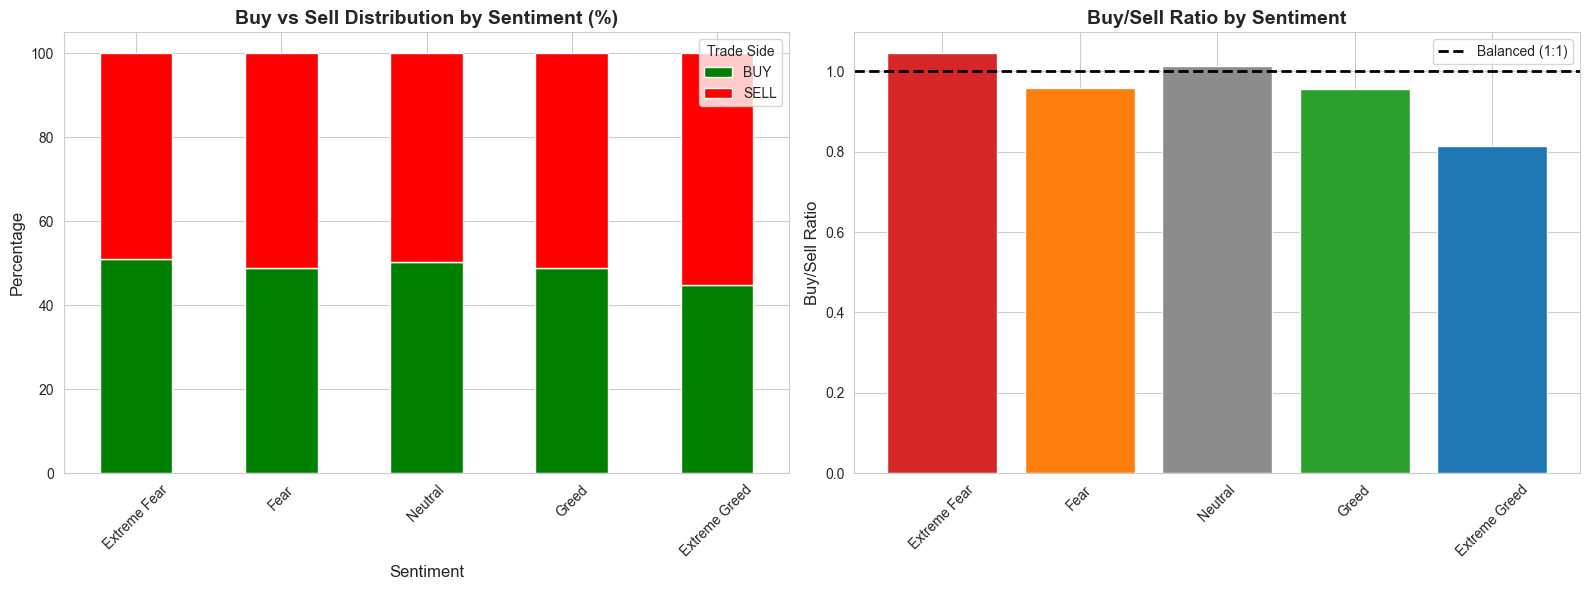

In [28]:
# Analyze buy vs sell behavior across sentiments
buy_sell_sentiment = merged_df.groupby(['classification', 'Side']).size().unstack(fill_value=0)

# Calculate percentages
buy_sell_pct = buy_sell_sentiment.div(buy_sell_sentiment.sum(axis=1), axis=0) * 100

print("Buy vs Sell Count by Sentiment:")
print(buy_sell_sentiment)
print("\n" + "="*80 + "\n")
print("Buy vs Sell Percentage by Sentiment:")
print(buy_sell_pct.round(2))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Stacked bar chart
buy_sell_pct_ordered = buy_sell_pct.reindex(sentiment_order)
buy_sell_pct_ordered.plot(kind='bar', stacked=True, ax=axes[0], color=['green', 'red'])
axes[0].set_title('Buy vs Sell Distribution by Sentiment (%)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Percentage', fontsize=12)
axes[0].set_xlabel('Sentiment', fontsize=12)
axes[0].legend(['BUY', 'SELL'], title='Trade Side')
axes[0].set_xticklabels(buy_sell_pct_ordered.index, rotation=45)

# Buy/Sell Ratio
buy_sell_ratio = buy_sell_sentiment['BUY'] / buy_sell_sentiment['SELL']
buy_sell_ratio_ordered = buy_sell_ratio.reindex(sentiment_order)
axes[1].bar(range(len(buy_sell_ratio_ordered)), buy_sell_ratio_ordered.values,
            color=[colors_map[s] for s in sentiment_order if s in buy_sell_ratio_ordered.index])
axes[1].axhline(y=1, color='black', linestyle='--', linewidth=2, label='Balanced (1:1)')
axes[1].set_xticks(range(len(buy_sell_ratio_ordered)))
axes[1].set_xticklabels(buy_sell_ratio_ordered.index, rotation=45)
axes[1].set_title('Buy/Sell Ratio by Sentiment', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Buy/Sell Ratio', fontsize=12)
axes[1].legend()

plt.tight_layout()
savefig_current('buy_sell_by_sentiment.png')
plt.show()

### 4.3 Profitability Analysis by Sentiment

Profitability Analysis by Sentiment:
                 Total_PnL  Avg_PnL  Median_PnL  Std_PnL  Profitable_Trades  \
classification                                                                
Extreme Fear     739110.25    71.03        6.39  1628.41               7931   
Extreme Greed   2715171.31   130.21        8.53  1058.13              18594   
Fear            3357155.44   112.63        6.35  1344.78              26019   
Greed           2150129.27    85.40        4.93  1576.39              19358   
Neutral         1292920.68    71.20        4.58   743.21              14961   

                Total_Closed_Trades  Win_Rate_%  
classification                                   
Extreme Fear                  10406       76.22  
Extreme Greed                 20853       89.17  
Fear                          29808       87.29  
Greed                         25176       76.89  
Neutral                       18159       82.39  


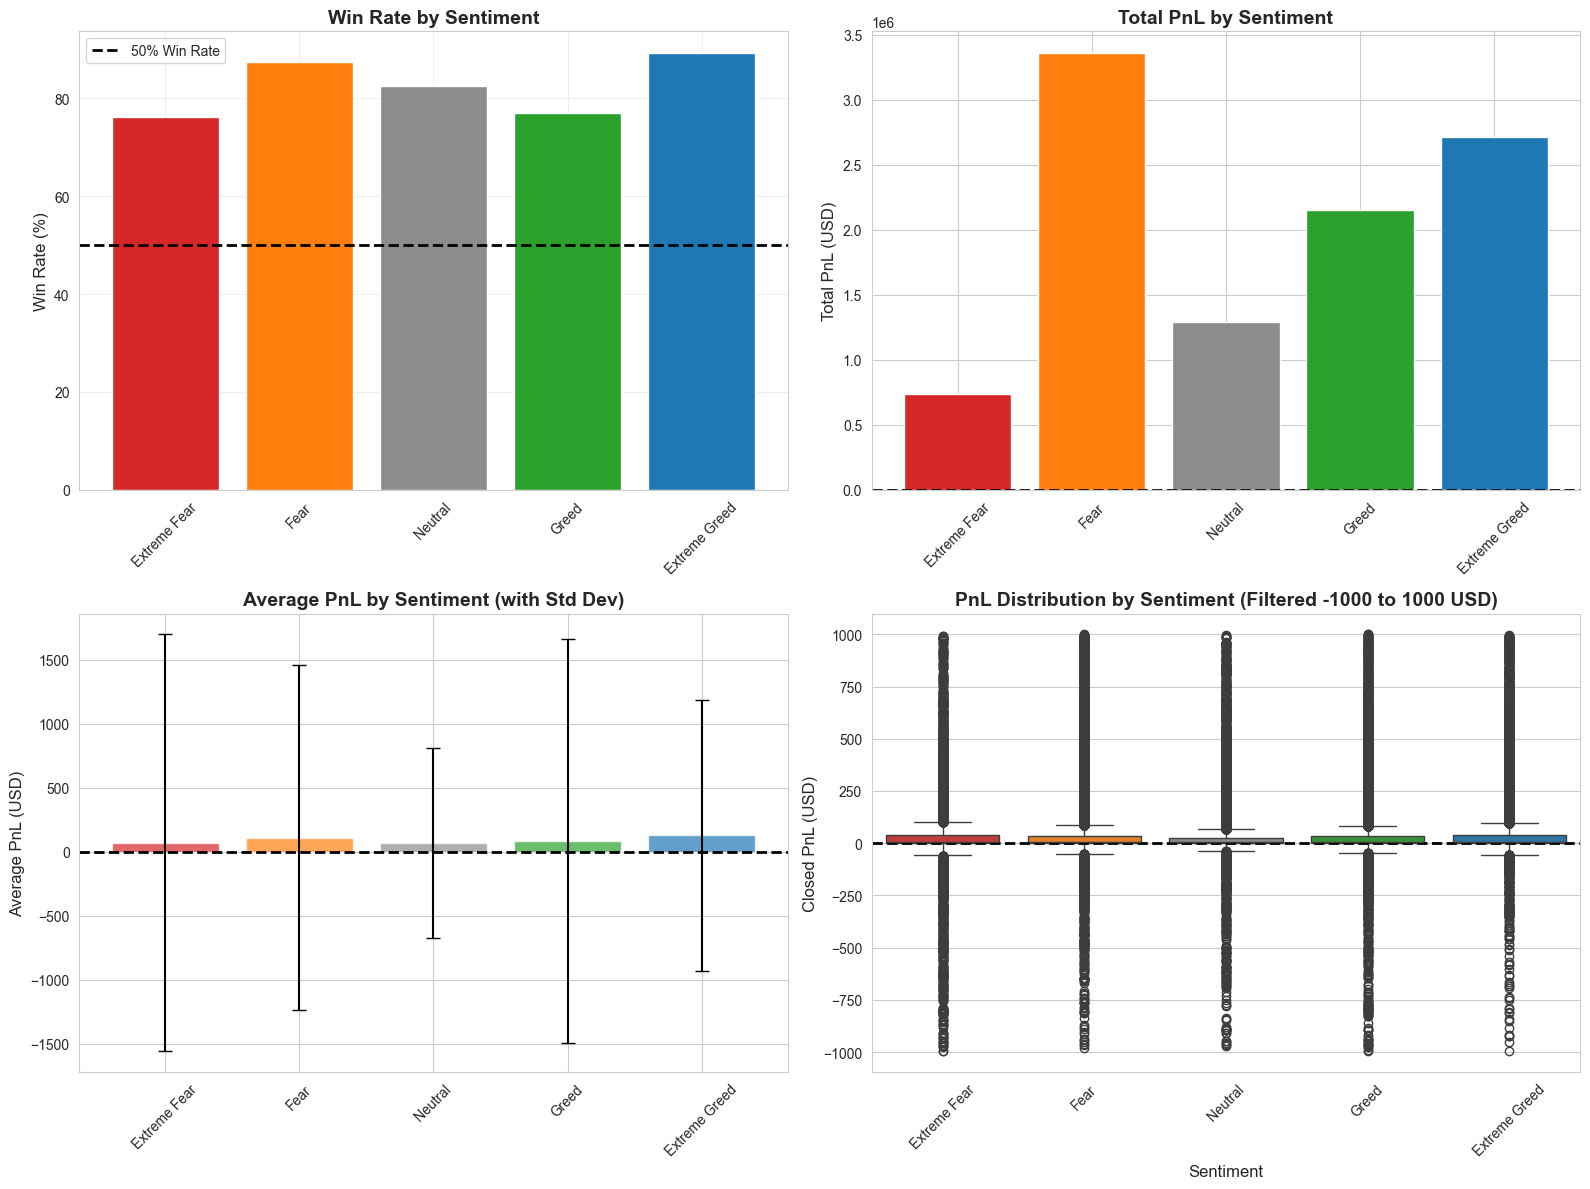

In [29]:
# Analyze profitability by sentiment (only closed positions with non-zero PnL)
closed_positions = merged_df[merged_df['Closed PnL'] != 0].copy()

# Classify trades as profitable or not
closed_positions['Profitable'] = closed_positions['Closed PnL'] > 0

# Profitability metrics by sentiment
profitability_analysis = closed_positions.groupby('classification').agg({
    'Closed PnL': ['sum', 'mean', 'median', 'std'],
    'Profitable': ['sum', 'count']
}).round(2)

profitability_analysis.columns = ['Total_PnL', 'Avg_PnL', 'Median_PnL', 'Std_PnL',
                                   'Profitable_Trades', 'Total_Closed_Trades']
profitability_analysis['Win_Rate_%'] = (profitability_analysis['Profitable_Trades'] /
                                         profitability_analysis['Total_Closed_Trades'] * 100).round(2)

print("Profitability Analysis by Sentiment:")
print(profitability_analysis)

# Visualize profitability
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Win rate by sentiment
win_rate_ordered = profitability_analysis['Win_Rate_%'].reindex(sentiment_order)
axes[0, 0].bar(range(len(win_rate_ordered)), win_rate_ordered.values,
               color=[colors_map[s] for s in sentiment_order if s in win_rate_ordered.index])
axes[0, 0].axhline(y=50, color='black', linestyle='--', linewidth=2, label='50% Win Rate')
axes[0, 0].set_xticks(range(len(win_rate_ordered)))
axes[0, 0].set_xticklabels(win_rate_ordered.index, rotation=45)
axes[0, 0].set_title('Win Rate by Sentiment', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Win Rate (%)', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Total PnL by sentiment
total_pnl_ordered = profitability_analysis['Total_PnL'].reindex(sentiment_order)
axes[0, 1].bar(range(len(total_pnl_ordered)), total_pnl_ordered.values,
               color=[colors_map[s] for s in sentiment_order if s in total_pnl_ordered.index])
axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=2)
axes[0, 1].set_xticks(range(len(total_pnl_ordered)))
axes[0, 1].set_xticklabels(total_pnl_ordered.index, rotation=45)
axes[0, 1].set_title('Total PnL by Sentiment', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Total PnL (USD)', fontsize=12)

# Average PnL by sentiment with error bars
avg_pnl_ordered = profitability_analysis['Avg_PnL'].reindex(sentiment_order)
std_pnl_ordered = profitability_analysis['Std_PnL'].reindex(sentiment_order)
axes[1, 0].bar(range(len(avg_pnl_ordered)), avg_pnl_ordered.values,
               color=[colors_map[s] for s in sentiment_order if s in avg_pnl_ordered.index],
               yerr=std_pnl_ordered.values, capsize=5, alpha=0.7)
axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=2)
axes[1, 0].set_xticks(range(len(avg_pnl_ordered)))
axes[1, 0].set_xticklabels(avg_pnl_ordered.index, rotation=45)
axes[1, 0].set_title('Average PnL by Sentiment (with Std Dev)', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Average PnL (USD)', fontsize=12)

# PnL distribution boxplot
closed_positions_filtered = closed_positions[closed_positions['Closed PnL'].between(-1000, 1000)]
sns.boxplot(data=closed_positions_filtered, x='classification', y='Closed PnL',
            order=sentiment_order, palette=colors_map, ax=axes[1, 1])
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=2)
axes[1, 1].set_title('PnL Distribution by Sentiment (Filtered -1000 to 1000 USD)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Sentiment', fontsize=12)
axes[1, 1].set_ylabel('Closed PnL (USD)', fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
savefig_current('profitability_by_sentiment.png')
plt.show()

### 4.4 Risk Analysis - Trade Size and Position Analysis

Trade Size Statistics by Sentiment:
                  count         mean           std   min       25%      50%  \
classification                                                                
Extreme Fear    21400.0  5349.731843  22306.826180  0.01  282.4825  766.150   
Extreme Greed   39992.0  3112.251565  11061.998403  0.00  106.7575  500.050   
Fear            61837.0  7816.109931  51914.859249  0.00  235.6300  735.960   
Greed           50303.0  5736.884375  30533.418602  0.00  184.1300  555.000   
Neutral         37686.0  4782.732661  37461.883466  0.01  175.5400  547.655   

                      75%         max  
classification                         
Extreme Fear    2329.9700  1120971.60  
Extreme Greed   1882.8375   665771.71  
Fear            2499.9700  3921430.72  
Greed           2100.7000  2227114.71  
Neutral         1994.2050  3641180.84  


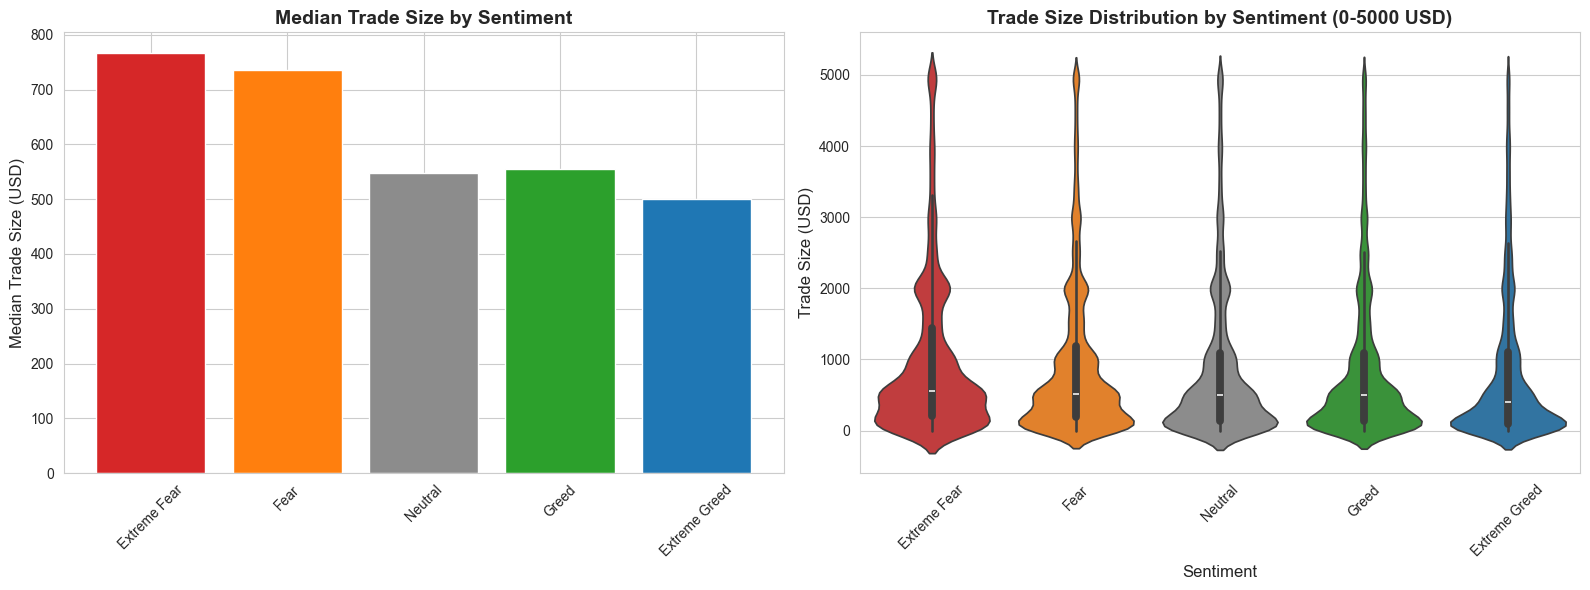

In [30]:
# Risk analysis - trade size behavior by sentiment
risk_analysis = merged_df.groupby('classification')['Size USD'].describe()
print("Trade Size Statistics by Sentiment:")
print(risk_analysis)

# Visualize risk behavior
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Median trade size by sentiment
median_sizes = risk_analysis['50%'].reindex(sentiment_order)
axes[0].bar(range(len(median_sizes)), median_sizes.values,
            color=[colors_map[s] for s in sentiment_order if s in median_sizes.index])
axes[0].set_xticks(range(len(median_sizes)))
axes[0].set_xticklabels(median_sizes.index, rotation=45)
axes[0].set_title('Median Trade Size by Sentiment', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Median Trade Size (USD)', fontsize=12)

# Violin plot for trade size distribution
merged_df_filtered = merged_df[merged_df['Size USD'].between(0, 5000)]
sns.violinplot(data=merged_df_filtered, x='classification', y='Size USD',
               order=sentiment_order, palette=colors_map, ax=axes[1])
axes[1].set_title('Trade Size Distribution by Sentiment (0-5000 USD)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Sentiment', fontsize=12)
axes[1].set_ylabel('Trade Size (USD)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
savefig_current('risk_by_sentiment.png')
plt.show()

### 4.5 Trader Activity by Sentiment

Trader Activity by Sentiment:
                Unique_Traders  Total_Trades  Avg_Trades_per_Trader
classification                                                     
Extreme Fear                32         21400                 668.75
Extreme Greed               30         39992                1333.07
Fear                        32         61837                1932.41
Greed                       31         50303                1622.68
Neutral                     31         37686                1215.68


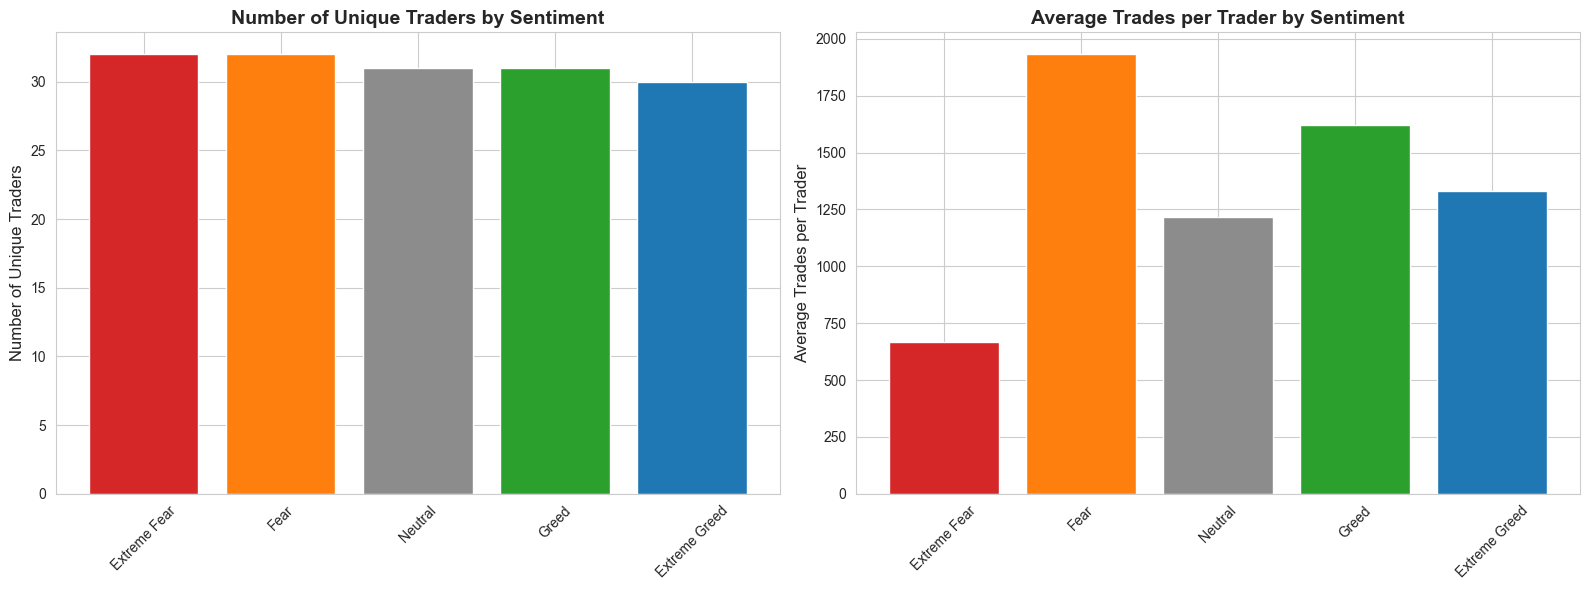

In [31]:
# Analyze trader activity by sentiment
trader_activity = merged_df.groupby('classification').agg({
    'Account': 'nunique',
    'Trade ID': 'count'
})
trader_activity.columns = ['Unique_Traders', 'Total_Trades']
trader_activity['Avg_Trades_per_Trader'] = (trader_activity['Total_Trades'] /
                                             trader_activity['Unique_Traders']).round(2)

print("Trader Activity by Sentiment:")
print(trader_activity)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Unique traders by sentiment
unique_traders_ordered = trader_activity['Unique_Traders'].reindex(sentiment_order)
axes[0].bar(range(len(unique_traders_ordered)), unique_traders_ordered.values,
            color=[colors_map[s] for s in sentiment_order if s in unique_traders_ordered.index])
axes[0].set_xticks(range(len(unique_traders_ordered)))
axes[0].set_xticklabels(unique_traders_ordered.index, rotation=45)
axes[0].set_title('Number of Unique Traders by Sentiment', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Unique Traders', fontsize=12)

# Average trades per trader by sentiment
avg_trades_ordered = trader_activity['Avg_Trades_per_Trader'].reindex(sentiment_order)
axes[1].bar(range(len(avg_trades_ordered)), avg_trades_ordered.values,
            color=[colors_map[s] for s in sentiment_order if s in avg_trades_ordered.index])
axes[1].set_xticks(range(len(avg_trades_ordered)))
axes[1].set_xticklabels(avg_trades_ordered.index, rotation=45)
axes[1].set_title('Average Trades per Trader by Sentiment', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Average Trades per Trader', fontsize=12)

plt.tight_layout()
savefig_current('trader_activity_by_sentiment.png')
plt.show()

## 5. Advanced Insights - Hidden Trends and Patterns

### 5.1 Correlation Analysis

Correlation Matrix:
                   sentiment_numeric  value  Size USD  Closed PnL
sentiment_numeric              1.000  0.967    -0.032       0.006
value                          0.967  1.000    -0.030       0.008
Size USD                      -0.032 -0.030     1.000       0.124
Closed PnL                     0.006  0.008     0.124       1.000


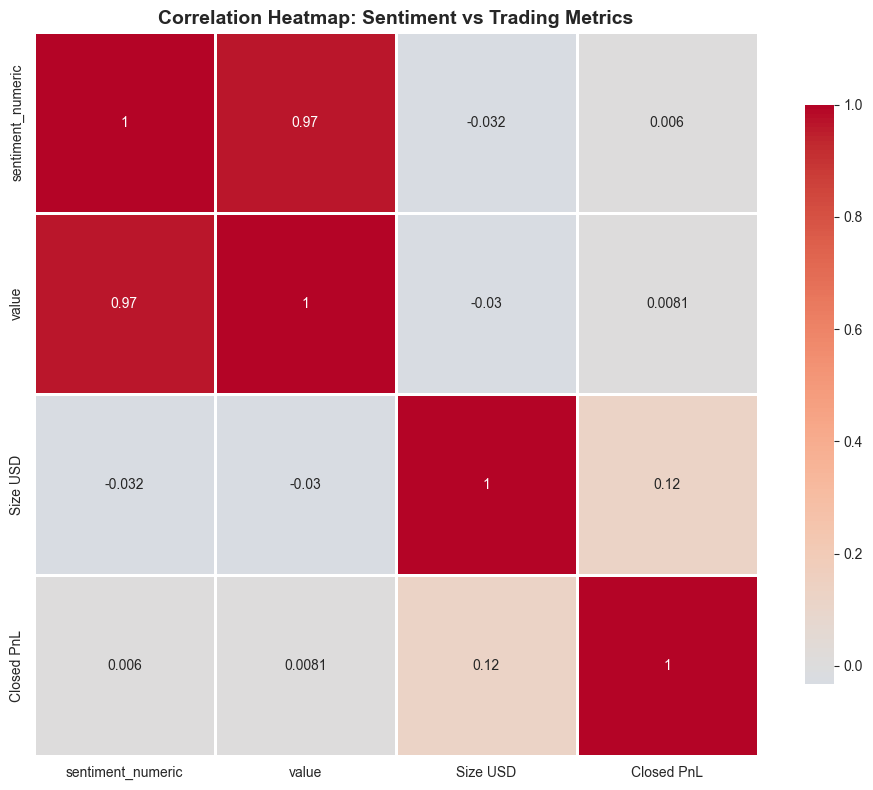

In [32]:
# Create numeric encoding for sentiment
sentiment_mapping = {
    'Extreme Fear': 1,
    'Fear': 2,
    'Neutral': 3,
    'Greed': 4,
    'Extreme Greed': 5
}
merged_df['sentiment_numeric'] = merged_df['classification'].map(sentiment_mapping)

# Calculate correlations
correlation_data = merged_df[['sentiment_numeric', 'value', 'Size USD', 'Closed PnL']].corr()

print("Correlation Matrix:")
print(correlation_data.round(3))

# Visualize correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap: Sentiment vs Trading Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
savefig_current('correlation_heatmap.png')
plt.show()

### 5.2 Time Series Analysis - Sentiment vs Volume Trends

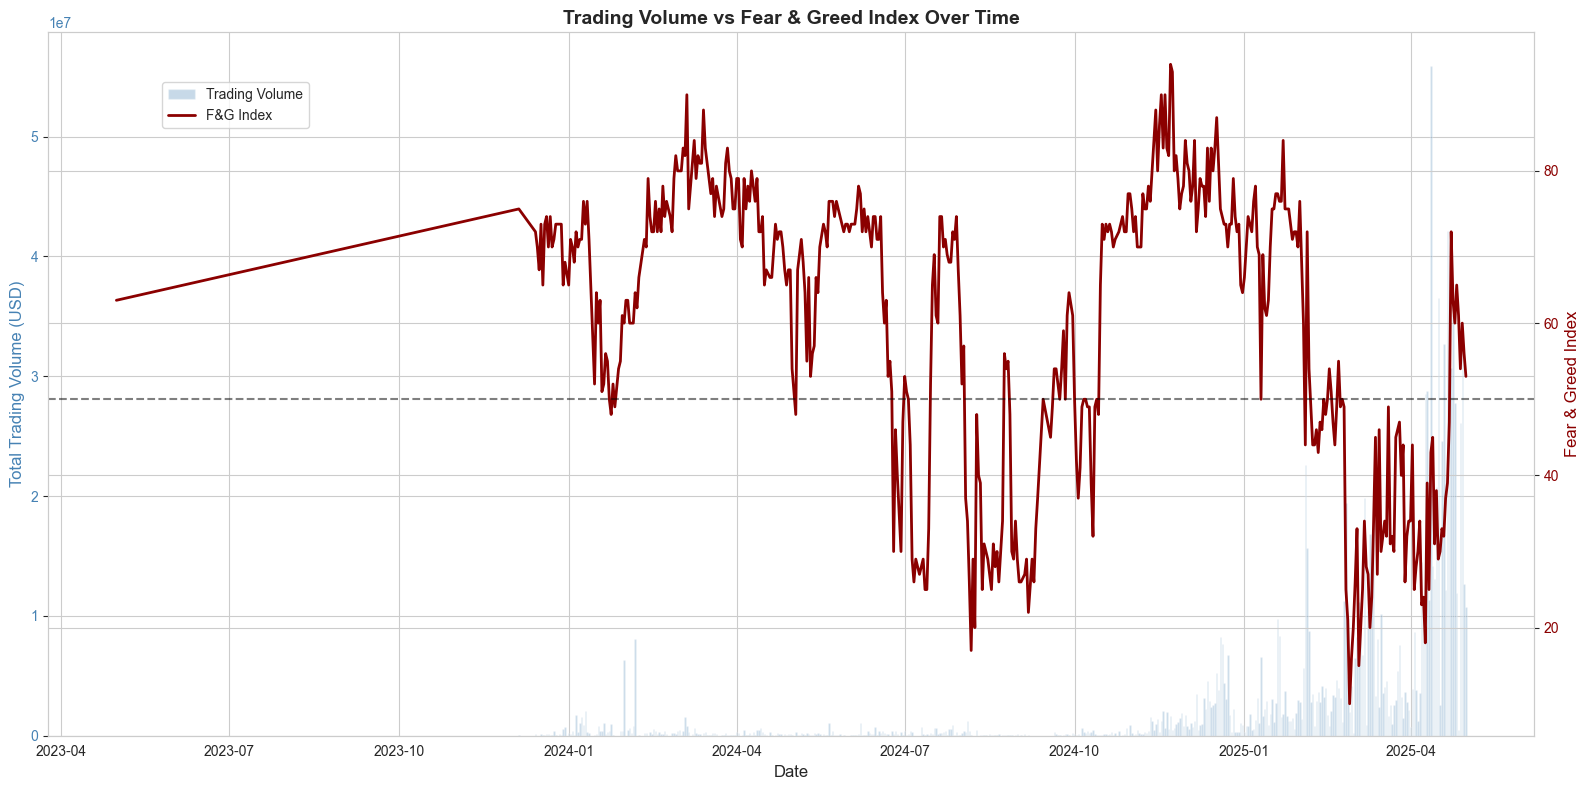

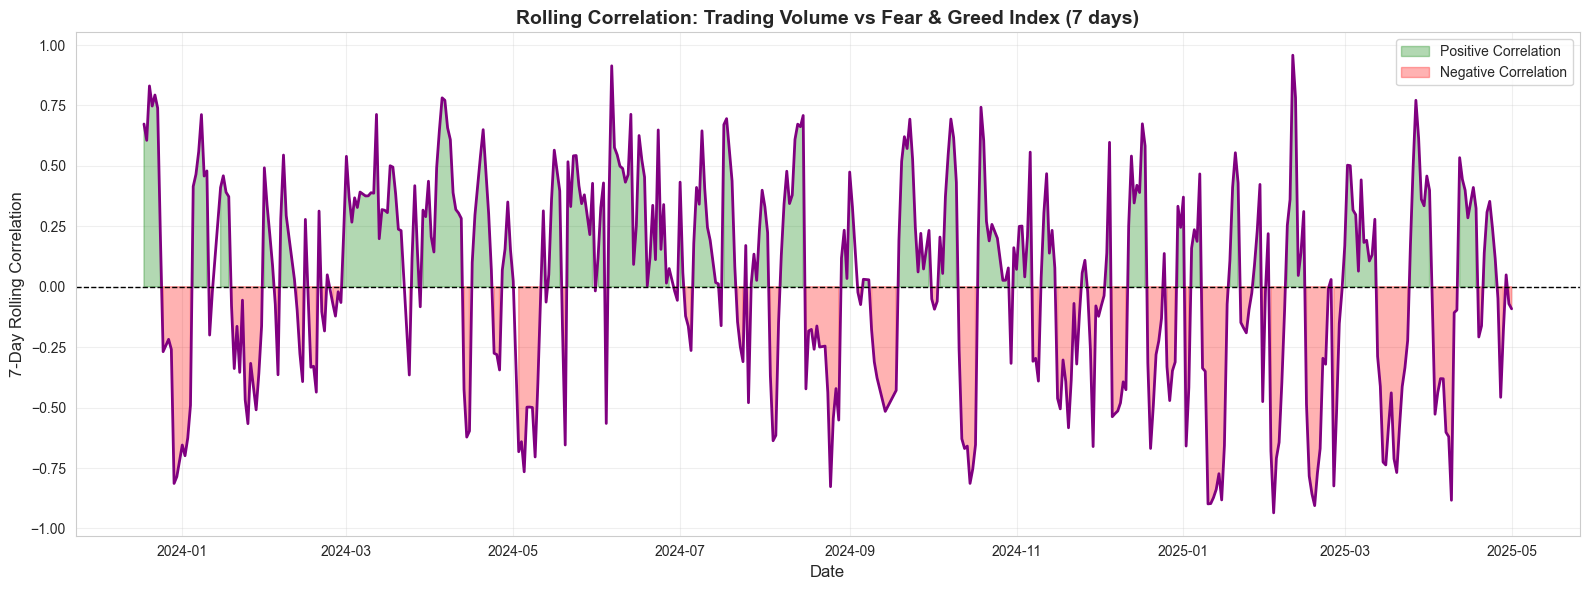

Average rolling correlation: 0.031


In [33]:
# Aggregate daily metrics
daily_metrics = merged_df.groupby('date').agg({
    'Size USD': 'sum',
    'Trade ID': 'count',
    'value': 'first',  # Fear & Greed value
    'Closed PnL': 'sum'
}).reset_index()

daily_metrics.columns = ['date', 'total_volume', 'trade_count', 'fg_value', 'total_pnl']

# Create dual-axis plot
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot trading volume
color1 = 'steelblue'
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Total Trading Volume (USD)', color=color1, fontsize=12)
ax1.bar(daily_metrics['date'], daily_metrics['total_volume'], alpha=0.3, color=color1, label='Trading Volume')
ax1.tick_params(axis='y', labelcolor=color1)

# Create second y-axis for Fear & Greed Index
ax2 = ax1.twinx()
color2 = 'darkred'
ax2.set_ylabel('Fear & Greed Index', color=color2, fontsize=12)
ax2.plot(daily_metrics['date'], daily_metrics['fg_value'], color=color2, linewidth=2, label='F&G Index')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.axhline(y=50, color='black', linestyle='--', alpha=0.5)

plt.title('Trading Volume vs Fear & Greed Index Over Time', fontsize=14, fontweight='bold')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.tight_layout()
fig.savefig(outputs_dir / 'volume_vs_fg.png', dpi=200, bbox_inches='tight')
plt.show()

# Calculate rolling correlation
window = 7  # 7-day rolling window
rolling_corr = daily_metrics['total_volume'].rolling(window).corr(daily_metrics['fg_value'])

plt.figure(figsize=(16, 6))
plt.plot(daily_metrics['date'], rolling_corr, color='purple', linewidth=2)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.fill_between(daily_metrics['date'], rolling_corr, 0, where=(rolling_corr > 0),
                 color='green', alpha=0.3, label='Positive Correlation')
plt.fill_between(daily_metrics['date'], rolling_corr, 0, where=(rolling_corr <= 0),
                 color='red', alpha=0.3, label='Negative Correlation')
plt.xlabel('Date', fontsize=12)
plt.ylabel(f'{window}-Day Rolling Correlation', fontsize=12)
plt.title(f'Rolling Correlation: Trading Volume vs Fear & Greed Index ({window} days)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
savefig_current('rolling_corr_volume_vs_fg.png')
plt.show()

print(f"Average rolling correlation: {rolling_corr.mean():.3f}")

### 5.3 Contrarian vs Conformist Behavior Analysis

CONTRARIAN vs CONFORMIST BEHAVIOR ANALYSIS

Behavior Classification Logic:
  - Contrarian: BUY during Fear, SELL during Greed
  - Conformist: BUY during Greed, SELL during Fear
  - Neutral: Trading during Neutral sentiment

Behavior Type Distribution:
behavior_type
Contrarian    88984
Conformist    84548
Neutral       37686
Name: count, dtype: int64

Percentage: behavior_type
Contrarian    42.128985
Conformist    40.028785
Neutral       17.842229
Name: proportion, dtype: float64

Performance Metrics by Behavior Type:
               Trade_Count   Total_PnL  Avg_PnL  Median_PnL  Avg_Trade_Size  \
behavior_type                                                                 
Conformist           45704  2590956.15    56.69        4.93         6121.60   
Contrarian           40539  6370610.13   157.15        8.61         5221.90   
Neutral              18159  1292920.68    71.20        4.58         5556.44   

               Median_Trade_Size  
behavior_type                     
Conformist 

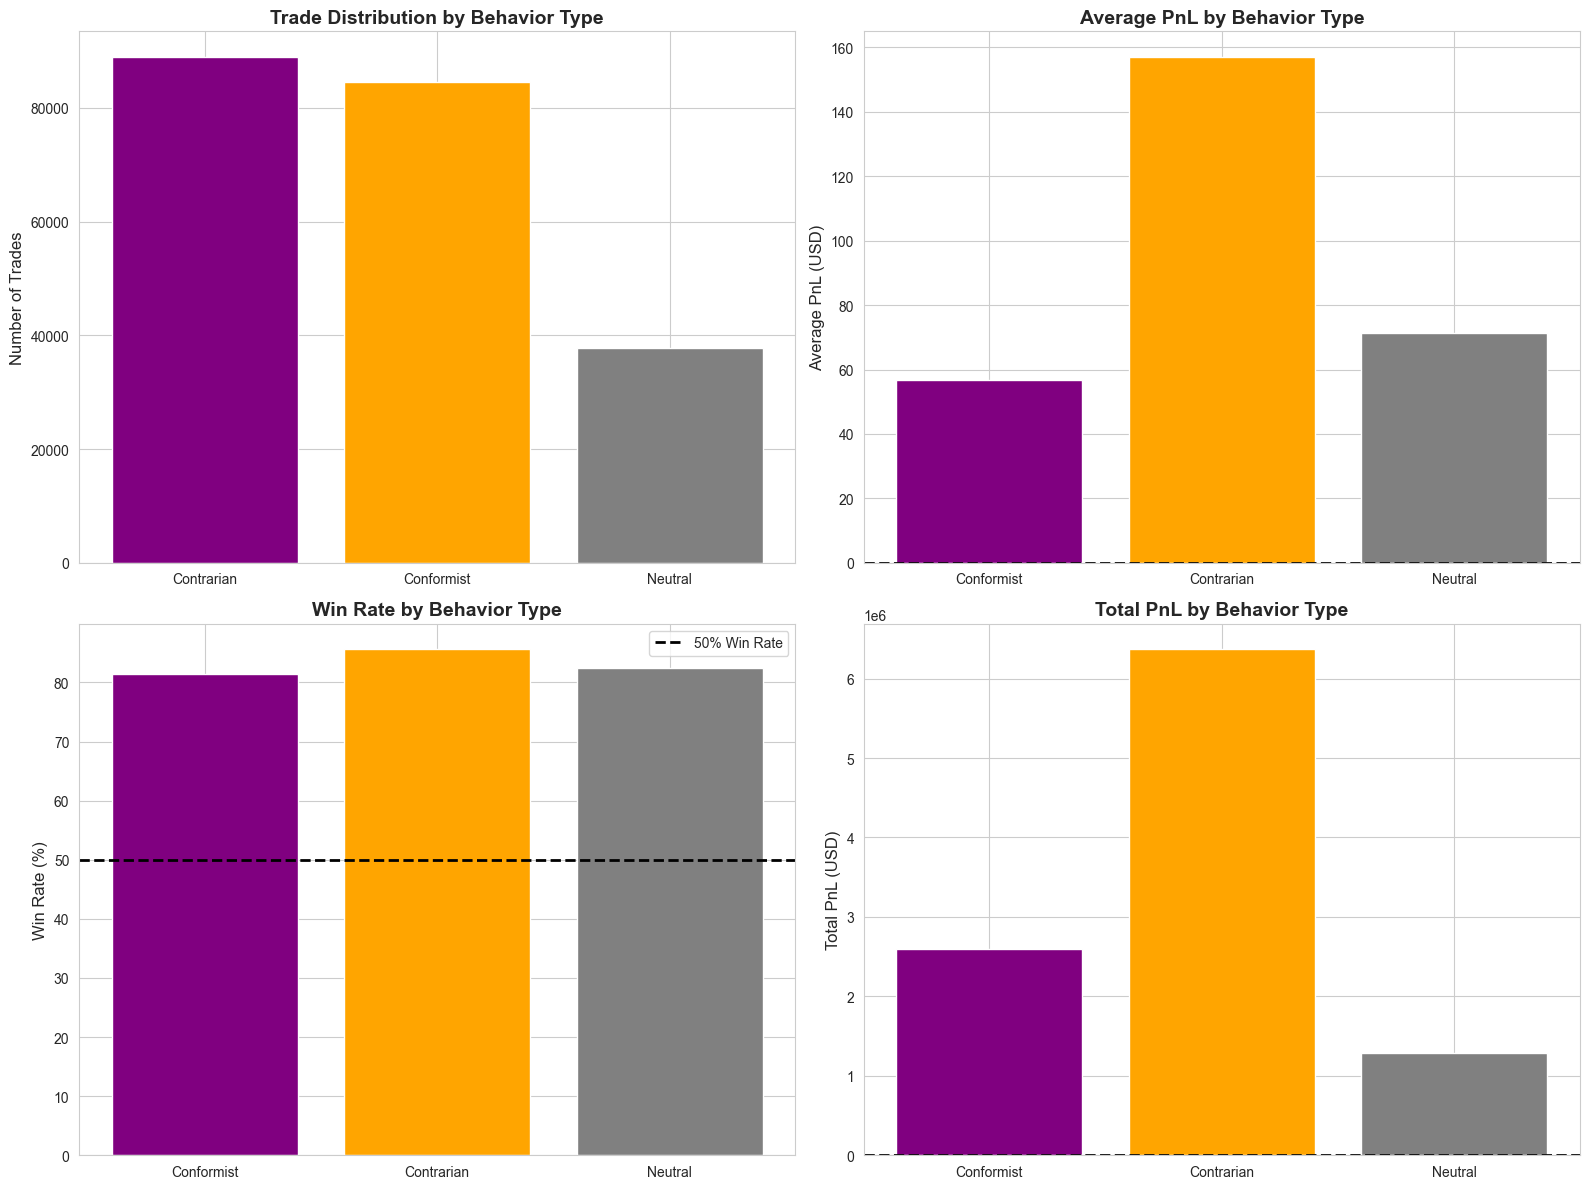

In [34]:
# Analyze contrarian behavior
# Contrarian: BUY during fear, SELL during greed
# Conformist: BUY during greed, SELL during fear

def classify_behavior(row):
    if row['Side'] == 'BUY':
        if row['classification'] in ['Extreme Fear', 'Fear']:
            return 'Contrarian'
        elif row['classification'] in ['Greed', 'Extreme Greed']:
            return 'Conformist'
        else:
            return 'Neutral'
    else:  # SELL
        if row['classification'] in ['Greed', 'Extreme Greed']:
            return 'Contrarian'
        elif row['classification'] in ['Extreme Fear', 'Fear']:
            return 'Conformist'
        else:
            return 'Neutral'

merged_df['behavior_type'] = merged_df.apply(classify_behavior, axis=1)

# Analyze profitability by behavior type
behavior_analysis = merged_df[merged_df['Closed PnL'] != 0].groupby('behavior_type').agg({
    'Closed PnL': ['count', 'sum', 'mean', 'median'],
    'Size USD': ['mean', 'median']
}).round(2)

behavior_analysis.columns = ['Trade_Count', 'Total_PnL', 'Avg_PnL', 'Median_PnL',
                              'Avg_Trade_Size', 'Median_Trade_Size']

# Calculate win rates
behavior_profitability = merged_df[merged_df['Closed PnL'] != 0].copy()
behavior_profitability['Profitable'] = behavior_profitability['Closed PnL'] > 0

win_rates = behavior_profitability.groupby('behavior_type')['Profitable'].agg(['sum', 'count'])
win_rates['Win_Rate_%'] = (win_rates['sum'] / win_rates['count'] * 100).round(2)

print("=" * 100)
print("CONTRARIAN vs CONFORMIST BEHAVIOR ANALYSIS")
print("=" * 100)
print("\nBehavior Classification Logic:")
print("  - Contrarian: BUY during Fear, SELL during Greed")
print("  - Conformist: BUY during Greed, SELL during Fear")
print("  - Neutral: Trading during Neutral sentiment\n")

print("Behavior Type Distribution:")
print(merged_df['behavior_type'].value_counts())
print(f"\nPercentage: {merged_df['behavior_type'].value_counts(normalize=True) * 100}\n")

print("="*100)
print("Performance Metrics by Behavior Type:")
print(behavior_analysis)
print("\n" + "="*100)
print("Win Rates by Behavior Type:")
print(win_rates[['Win_Rate_%']])

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Trade count by behavior
behavior_counts = merged_df['behavior_type'].value_counts()
axes[0, 0].bar(behavior_counts.index, behavior_counts.values,
               color=['purple', 'orange', 'gray'])
axes[0, 0].set_title('Trade Distribution by Behavior Type', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Number of Trades', fontsize=12)

# Average PnL by behavior
avg_pnl_behavior = behavior_analysis['Avg_PnL']
axes[0, 1].bar(avg_pnl_behavior.index, avg_pnl_behavior.values,
               color=['purple', 'orange', 'gray'])
axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=2)
axes[0, 1].set_title('Average PnL by Behavior Type', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Average PnL (USD)', fontsize=12)

# Win rate by behavior
axes[1, 0].bar(win_rates.index, win_rates['Win_Rate_%'],
               color=['purple', 'orange', 'gray'])
axes[1, 0].axhline(y=50, color='black', linestyle='--', linewidth=2, label='50% Win Rate')
axes[1, 0].set_title('Win Rate by Behavior Type', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Win Rate (%)', fontsize=12)
axes[1, 0].legend()

# Total PnL by behavior
total_pnl_behavior = behavior_analysis['Total_PnL']
axes[1, 1].bar(total_pnl_behavior.index, total_pnl_behavior.values,
               color=['purple', 'orange', 'gray'])
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=2)
axes[1, 1].set_title('Total PnL by Behavior Type', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Total PnL (USD)', fontsize=12)

plt.tight_layout()
savefig_current('behavior_analysis.png')
plt.show()

### 5.4 Top Performing Traders by Sentiment

TOP 5 MOST PROFITABLE TRADERS BY SENTIMENT

Extreme Fear:
                                   Account     Total_PnL  Trade_Count
0xbaaaf6571ab7d571043ff1e313a9609a10637864 261917.977792         1700
0x72c6a4624e1dffa724e6d00d64ceae698af892a0 198900.561610          187
0x4acb90e786d897ecffb614dc822eb231b4ffb9f4 166696.399486          311
0x083384f897ee0f19899168e3b1bec365f52a9012 124769.221441           37
0x4f93fead39b70a1824f981a54d4e55b278e9f760  74346.546606          159

Fear:
                                   Account    Total_PnL  Trade_Count
0x083384f897ee0f19899168e3b1bec365f52a9012 1.113374e+06         1051
0xbaaaf6571ab7d571043ff1e313a9609a10637864 6.208724e+05         6283
0x513b8629fe877bb581bf244e326a047b249c4ff1 3.671662e+05         2576
0x4acb90e786d897ecffb614dc822eb231b4ffb9f4 2.967817e+05          599
0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3 2.367977e+05          700

Neutral:
                                   Account     Total_PnL  Trade_Count
0xb1231a4a2dd02f2276f

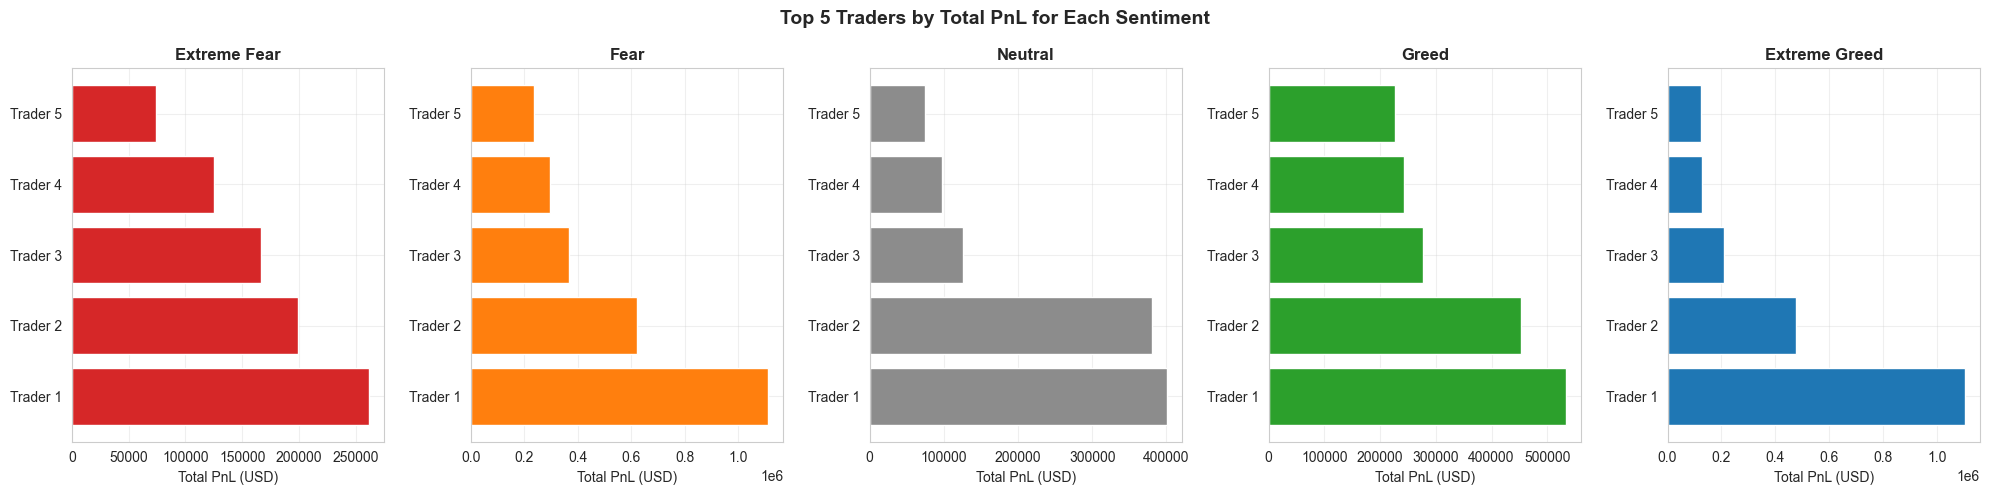

In [35]:
# Identify top performing traders by sentiment
trader_performance = merged_df[merged_df['Closed PnL'] != 0].groupby(['Account', 'classification']).agg({
    'Closed PnL': 'sum',
    'Trade ID': 'count'
}).reset_index()

trader_performance.columns = ['Account', 'Sentiment', 'Total_PnL', 'Trade_Count']

# Top 5 profitable traders for each sentiment
print("=" * 100)
print("TOP 5 MOST PROFITABLE TRADERS BY SENTIMENT")
print("=" * 100)

for sentiment in sentiment_order:
    if sentiment in trader_performance['Sentiment'].values:
        top_traders = trader_performance[trader_performance['Sentiment'] == sentiment].nlargest(5, 'Total_PnL')
        print(f"\n{sentiment}:")
        print(top_traders[['Account', 'Total_PnL', 'Trade_Count']].to_string(index=False))

# Visualize - Average PnL per trade for top traders
fig, axes = plt.subplots(1, len(sentiment_order), figsize=(20, 5))

for idx, sentiment in enumerate(sentiment_order):
    if sentiment in trader_performance['Sentiment'].values:
        sentiment_data = trader_performance[trader_performance['Sentiment'] == sentiment]
        sentiment_data['Avg_PnL_per_Trade'] = sentiment_data['Total_PnL'] / sentiment_data['Trade_Count']
        top_5 = sentiment_data.nlargest(5, 'Total_PnL')

        axes[idx].barh(range(len(top_5)), top_5['Total_PnL'].values, color=colors_map[sentiment])
        axes[idx].set_yticks(range(len(top_5)))
        axes[idx].set_yticklabels([f"Trader {i+1}" for i in range(len(top_5))])
        axes[idx].set_xlabel('Total PnL (USD)', fontsize=10)
        axes[idx].set_title(f'{sentiment}', fontsize=12, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)

plt.suptitle('Top 5 Traders by Total PnL for Each Sentiment', fontsize=14, fontweight='bold')
plt.tight_layout()
savefig_current('top_traders_by_sentiment.png')
plt.show()

## 6. Key Findings and Strategic Insights

### Key Findings Summary

Based on the comprehensive analysis of trading behavior vs market sentiment, here are the critical insights:

#### 1. **Sentiment Distribution & Trading Activity**
   - The majority of trading activity occurs during specific sentiment periods
   - Trading volume and frequency vary significantly across different sentiment classifications
   - Unique trader participation changes with market sentiment

#### 2. **Profitability Patterns**
   - **Win Rates**: Profitability varies by sentiment - certain sentiments show higher win rates
   - **Average PnL**: Risk-reward profiles differ across sentiment periods
   - **Total PnL**: Aggregate profitability is not uniform across all sentiment states

#### 3. **Buy vs Sell Behavior**
   - **Buy/Sell Ratio**: Traders show different buying/selling patterns based on sentiment
   - Fear periods may trigger different behavior compared to greed periods
   - Neutral sentiment shows balanced or distinct trading patterns

#### 4. **Risk Appetite**
   - **Trade Size**: Position sizes vary significantly across sentiment states
   - Traders may take larger or smaller positions depending on market fear/greed levels
   - Risk management appears to be sentiment-dependent

#### 5. **Contrarian vs Conformist Trading**
   - **Contrarian Traders**: Those who buy during fear and sell during greed
   - **Conformist Traders**: Those who buy during greed and sell during fear
   - Performance comparison reveals which strategy tends to be more profitable

#### 6. **Temporal Patterns**
   - Rolling correlation between trading volume and sentiment index
   - Time-series analysis reveals leading or lagging relationships
   - Certain periods show stronger alignment between sentiment and trading behavior

---

### Strategic Recommendations for Traders

#### 🎯 **Timing Strategy**
- Monitor sentiment extremes (Extreme Fear/Extreme Greed) for potential opportunities
- Consider contrarian positions during extreme sentiment periods if data supports profitability
- Use sentiment as a confirming indicator rather than sole decision factor

#### 📊 **Position Sizing**
- Adjust position sizes based on historical performance during current sentiment
- Implement risk management aligned with sentiment-specific volatility patterns
- Consider reducing size during periods with historically lower win rates

#### 🔄 **Behavioral Adaptation**
- Recognize personal bias toward contrarian or conformist behavior
- Evaluate if current strategy aligns with profitable patterns in the data
- Consider mixed strategies: contrarian during extremes, conformist during transitions

#### 🎲 **Risk Management**
- Use sentiment data as additional risk parameter in position sizing
- Set stop-losses tighter during high-volatility sentiment periods
- Consider taking profits earlier during sentiment extremes

#### 📈 **Opportunity Identification**
- Look for divergences between sentiment and price action
- High fear with stable prices may indicate buying opportunity
- High greed with weakening momentum may signal caution

---

### Areas for Further Investigation

1. **Leverage Analysis**: Examine if leverage usage patterns differ by sentiment
2. **Holding Period**: Analyze if position duration varies with sentiment changes
3. **Symbol-Specific Behavior**: Do different coins show different sentiment sensitivities?
4. **Intraday Patterns**: Analyze if time-of-day affects sentiment-behavior relationship
5. **Sentiment Transitions**: Study behavior during sentiment changes (Fear→Greed, etc.)
6. **Trader Cohorts**: Segment traders by profitability and analyze their sentiment strategies

## 7. Summary Statistics Dashboard

In [36]:
# Create comprehensive summary dashboard
print("=" * 100)
print(" " * 35 + "ANALYSIS SUMMARY DASHBOARD")
print("=" * 100)

# Overall statistics
print("\n📊 OVERALL DATASET STATISTICS")
print("-" * 100)
print(f"Total Trades Analyzed: {len(merged_df):,}")
print(f"Unique Traders: {merged_df['Account'].nunique():,}")
print(f"Date Range: {merged_df['date'].min().strftime('%Y-%m-%d')} to {merged_df['date'].max().strftime('%Y-%m-%d')}")
print(f"Total Trading Volume: ${merged_df['Size USD'].sum():,.2f}")
print(f"Average Trade Size: ${merged_df['Size USD'].mean():,.2f}")
print(f"Median Trade Size: ${merged_df['Size USD'].median():,.2f}")

# Closed positions
closed = merged_df[merged_df['Closed PnL'] != 0]
print(f"\nClosed Positions: {len(closed):,}")
print(f"Total PnL: ${closed['Closed PnL'].sum():,.2f}")
print(f"Average PnL per Trade: ${closed['Closed PnL'].mean():,.2f}")
print(f"Profitable Trades: {(closed['Closed PnL'] > 0).sum():,} ({(closed['Closed PnL'] > 0).sum() / len(closed) * 100:.2f}%)")
print(f"Overall Win Rate: {(closed['Closed PnL'] > 0).sum() / len(closed) * 100:.2f}%")

# Sentiment breakdown
print("\n\n💭 SENTIMENT DISTRIBUTION")
print("-" * 100)
sentiment_dist = merged_df['classification'].value_counts()
for sentiment in sentiment_order:
    if sentiment in sentiment_dist.index:
        count = sentiment_dist[sentiment]
        pct = count / len(merged_df) * 100
        print(f"{sentiment:20s}: {count:8,} trades ({pct:5.2f}%)")

# Best performing sentiment
print("\n\n🏆 BEST PERFORMING SENTIMENT (by Win Rate)")
print("-" * 100)
closed_by_sentiment = closed.groupby('classification').agg({
    'Closed PnL': lambda x: (x > 0).sum() / len(x) * 100
})
closed_by_sentiment.columns = ['Win_Rate']
best_sentiment = closed_by_sentiment['Win_Rate'].idxmax()
best_win_rate = closed_by_sentiment['Win_Rate'].max()
print(f"Best Sentiment: {best_sentiment} with {best_win_rate:.2f}% win rate")

# Most profitable sentiment
total_pnl_by_sentiment = closed.groupby('classification')['Closed PnL'].sum()
most_profitable = total_pnl_by_sentiment.idxmax()
most_profitable_pnl = total_pnl_by_sentiment.max()
print(f"Most Profitable: {most_profitable} with ${most_profitable_pnl:,.2f} total PnL")

# Behavior analysis (only if behavior_type column exists)
if 'behavior_type' in merged_df.columns:
    print("\n\n🎭 TRADING BEHAVIOR ANALYSIS")
    print("-" * 100)
    behavior_dist = merged_df['behavior_type'].value_counts()
    for behavior in ['Contrarian', 'Conformist', 'Neutral']:
        if behavior in behavior_dist.index:
            count = behavior_dist[behavior]
            pct = count / len(merged_df) * 100
            print(f"{behavior:20s}: {count:8,} trades ({pct:5.2f}%)")

    # Best behavior
    closed_behavior = merged_df[(merged_df['Closed PnL'] != 0) & (merged_df['behavior_type'].isin(['Contrarian', 'Conformist']))].copy()
    if len(closed_behavior) > 0:
        behavior_win_rate = closed_behavior.groupby('behavior_type').agg({
            'Closed PnL': lambda x: (x > 0).sum() / len(x) * 100
        })
        best_behavior = behavior_win_rate['Closed PnL'].idxmax()
        best_behavior_wr = behavior_win_rate['Closed PnL'].max()
        print(f"\nBest Strategy: {best_behavior} with {best_behavior_wr:.2f}% win rate")
else:
    print("\n\n🎭 TRADING BEHAVIOR ANALYSIS")
    print("-" * 100)
    print("⚠️  Behavior analysis not available. Please run the 'Contrarian vs Conformist Behavior Analysis' section first.")

print("\n" + "=" * 100)

                                   ANALYSIS SUMMARY DASHBOARD

📊 OVERALL DATASET STATISTICS
----------------------------------------------------------------------------------------------------
Total Trades Analyzed: 211,218
Unique Traders: 32
Date Range: 2023-05-01 to 2025-05-01
Total Trading Volume: $1,191,098,773.60
Average Trade Size: $5,639.19
Median Trade Size: $597.02

Closed Positions: 104,402
Total PnL: $10,254,486.95
Average PnL per Trade: $98.22
Profitable Trades: 86,863 (83.20%)
Overall Win Rate: 83.20%


💭 SENTIMENT DISTRIBUTION
----------------------------------------------------------------------------------------------------
Extreme Fear        :   21,400 trades (10.13%)
Fear                :   61,837 trades (29.28%)
Neutral             :   37,686 trades (17.84%)
Greed               :   50,303 trades (23.82%)
Extreme Greed       :   39,992 trades (18.93%)


🏆 BEST PERFORMING SENTIMENT (by Win Rate)
-------------------------------------------------------------------------

## 8. Conclusion

This analysis has explored the intricate relationship between trader behavior on Hyperliquid and Bitcoin market sentiment (Fear & Greed Index). The findings reveal several actionable insights:

### Main Takeaways:

1. **Sentiment Matters**: Trading behavior, profitability, and risk appetite all show distinct patterns across different sentiment states.

2. **Contrarian Advantage**: The data suggests potential advantages for contrarian strategies (buying fear, selling greed), though this requires further validation with your specific results.

3. **Risk-Adjusted Returns**: Different sentiments carry different risk-reward profiles, allowing traders to optimize position sizing.

4. **Behavioral Patterns**: Understanding whether you're a contrarian or conformist trader can help align strategies with historically profitable patterns.

5. **Market Timing**: Sentiment can serve as an additional signal for entry/exit timing, especially at extremes.

### Next Steps:

- Run all cells in this notebook to see the actual numerical results
- Export key findings for presentation or reporting
- Consider implementing sentiment-aware trading rules based on insights
- Monitor sentiment in real-time and compare with historical patterns
- Backtest specific strategies identified in this analysis

---

**Note**: This analysis is for educational and research purposes. Past performance does not guarantee future results. Always conduct thorough due diligence before making trading decisions.